# Modeling and Simulation in Python

Chapter 6: Analysis

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# If you want the figures to appear in the notebook, 
# and you want to interact with them, use
# %matplotlib notebook

# If you want the figures to appear in the notebook, 
# and you don't want to interact with them, use
# %matplotlib inline

# If you want the figures to appear in separate windows, use
# %matplotlib qt5

# To switch from one to another, you have to select Kernel->Restart

%matplotlib inline

from modsim import *

### Code from the previous chapter

`make_system`, `plot_results`, and `calc_total_infected` are unchanged.

In [62]:
def make_system(beta1, gamma1, beta2, gamma2, t_b):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init1 = State(S1=89, I1=1, R1=0, S2=0, I2=0, R2=0, S3=0, I3a=0, I3b = 0, R3=0, I4=0)
    seriesS = TimeSeries()
    seriesI = TimeSeries()
    seriesR = TimeSeries()
    #S1: num people who didn't get either disease
    #I1: num people who are infected by disease A
    #R1: num people who recovered from disease A
    #S2: num people who already recovered from only one disease (same as R1 + R2)
    #I2: num people who are infected by disease B
    #R2: num people who recovered from disease B
    #S3: num people who is infected by only one disease (same as I1 + I2)
    #I3a: num people who reovered from disease a and is infected by b
    #I3b: num people who recovered from disease b and are infected by disease a
    #R3: num people who recovered from both diseases
    #I4: num people infected to both diseases at same time 
    #seriesS: total num people susceptible 
    #seriesI: total num people infected
    #seriesR: total num people who recovered 
    
    init1 /= np.sum(init1)

    t0 = 0
    t_end = 7 * 14*2
    t_b = t_b
    print(t_b)

    return System(init1=init1, t0=t0, t_end=t_end, t_b = t_b, seriesS=seriesS, seriesI=seriesI, seriesR=seriesR,
                  beta1=beta1, gamma1=gamma1, beta2=beta2, gamma2=gamma2)

In [63]:
def calc_total_infected(system):
    """Fraction of population infected during the simulation.
    
    system: System object with results.
    
    returns: fraction of population
    """
    frame = system.results
    return frame.S[system.t0] - frame.S[system.t_end]

In [64]:
def plot_results(S, I, R):
    """Plot the results of a SIR model.
    
    S: TimeSeries
    I: TimeSeries
    R: TimeSeries
    """
    plot(S, '--', color='blue', label='Susceptible')
    plot(I, '-', color='red', label='Infected')
    plot(R, ':', color='green', label='Resistant')
    decorate(xlabel='Time (days)',
             ylabel='Fraction of population')

Here's an updated version of `run_simulation` that uses `unpack`.

In [65]:
def run_simulation(system):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init1.index)
    frame.loc[t0] = init1
    seriesS[t0] = init1.S1
    seriesI[t0] = init1.I1
    seriesR[t0] = init1.R1
    
    for i in linrange(t0, t_end):
        if i < t_b:
            frame.loc[i+1] = update1(frame.loc[i], system, i)
        else:
            frame.loc[i+1] = update2(frame.loc[i], system, i)
    
    system.results = frame

In [66]:
def update1(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s1, i1, r1, s2, i2, r2, s3, i3a, i3b, r3, i4 = state

    infected = beta1 * i1 * s1    
    recovered = gamma1 * i1
    
    s1 -= infected
    i1 += infected - recovered
    r1 += recovered
    
    seriesS[i] = s1 + s2 + s3
    seriesI[i] = i1 + i2 + i3a + i3b + i4
    seriesR[i] = r1 + r2 + r3
    
    return State(S1=s1, I1=i1, R1=r1, S2=s2, I2=i2, R2=r2, S3=s3, I3a=i3a, I3b = i3b, R3=r3, I4=i4)

In [67]:
def update2(state, system, i):
    """Update the SIR model.
    
    state: State (s, i, r)
    system: System object
    
    returns: State (sir)
    """
    unpack(system)
    s1, i1, r1, s2, i2, r2, s3, i3a, i3b, r3, i4 = state
    #S1: num people who didn't get either disease
    #I1: num people who are infected by disease A
    #R1: num people who recovered from disease A
    #S2: num people who already recovered from only one disease (same as R1 + R2)
    #I2: num people who are infected by disease B
    #R2: num people who recovered from disease B
    #S3: num people who is infected by only one disease (same as I1 + I2)
    #I3a: num people who recovered from disease a and is infected by b
    #I3b: num people who recovered from disease b and are infected by disease a
    #R3: num people who recovered from both diseases
    #I4: num people infected to both diseases at same time
    
    if i2 < 1:
        i2 = 1
        
    i1 = beta1 * i1 * s1  
    s1 = s1 - i1
    i2 = beta2 * i2 * s1
    s1 = s1 - i2
    s3 = i1 + i2 
    
    i4a = beta2 * i1 * i2 #needs to be slightly modified due to assumptions
    i1 = i1 - i4a
    i4b = beta1 * i2 * i1 #needs to be slightly modified due to assumptions
    i2 = i2 - i4b
    i4 = i4a + i4b
    
    r1 = gamma1 * i1
    i1 = i1 - r1
    r2 = gamma2 * i2
    i2 = i2 - r2
    s2 = r1 + r2
    
    i3a = beta2 * r1 * i2 #needs to be slightly modified due to assumptions  
    r1 = r1 - i3a
    i3b = beta1 * r2 * i1 #needs to be slightly modified due to assumptions
    r2 = r2 - i3b
    
    r3a = i3a * gamma2
    i3a = i3a - r3a
    r3b = i3b * gamma1
    i3b = i3b - r3b
    r3 = r3a + r3b
    r3 = r3 + (gamma2 * gamma1 * i4) #might need to think this through a little with what happens to people infected with both diseases
     
    #i4 = beta1 * i1 * i2 + beta2 * i2 * i1 
    #needs to be slightly modified due to assumptions
    #i4 = (beta1 * i1 * i2 + beta2 * i2 * i1) / 2
    
    
    seriesS[i] = s1 + s2 + s3
    seriesI[i] = i1 + i2 + i3b + i3a + i4
    seriesR[i] = r1 + r2 + r3
    
    return State(S1=s1, I1=i1, R1=r1, S2=s2, I2=i2, R2=r2, S3=s3, I3a=i3a, I3b = i3b,R3=r3, I4=i4)

Test the updated code with this example.

In [74]:
system = make_system(0.333, 0.50, 0, 0, 80)
run_simulation(system)
system.results.head()


80


,S1,I1,R1,S2,I2,R2,S3,I3a,I3b,R3,I4
0,0.988889,0.011111,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.985230,0.009214,0.005556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.982207,0.007630,0.010163,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.979711,0.006311,0.013978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.977652,0.005214,0.017133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


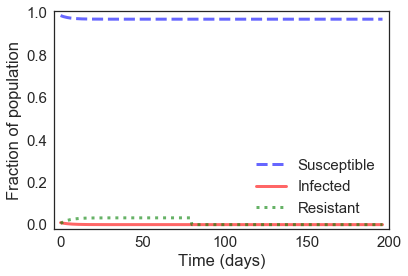

In [75]:
frame = system.results
plot_results(system.seriesS, system.seriesI, system.seriesR)